### This code tries to solve the KPCA pre-imaging with added "salt and pepper" noise

In [2]:
import pandas as pd
import numpy as np
from numpy.linalg import eig
from scipy.linalg import svd
from matplotlib import image
from matplotlib import pyplot as plt
import cv2

In [3]:
import os

from sklearn.decomposition import PCA, KernelPCA
from sklearn.model_selection import train_test_split

In [4]:
## image read in loop
path = '/Users/yyj/Desktop/math123/final_project/chest_xray/train/NORMAL/'
X = np.zeros((300, 200000))
## number of images
n = 0


for file in os.listdir(path):
    if n < 300:
        image_path = f"{path}{file}"
        #print(str(image_path))
        size = os.path.getsize(image_path)
        if size > 700000:
            #print(str(image_path))
            #image_path = path + str(file)
            #image_path = os.path.join(path, str(file))
            chest = image.imread(image_path)
            chest_cut = chest[600:1000, 500:1000]
            X[n] = chest_cut.reshape((1,200000))
            n = n+1

In [5]:
X.shape
#this the raw data, without anything

(300, 200000)

In [6]:
X #see the raw data

array([[126., 126., 135., ..., 120., 120., 129.],
       [165., 168., 165., ..., 206., 207., 208.],
       [187., 187., 181., ..., 178., 179., 182.],
       ...,
       [144., 145., 148., ..., 207., 213., 215.],
       [118., 116., 115., ..., 209., 210., 209.],
       [105., 107., 108., ..., 192., 190., 190.]])

## 1. salt and pepper noise

In [7]:
#first add the noise

import random 

def sp_noise(image,prob):
    '''
    Add salt and pepper noise to image
    prob: Probability of the noise
    '''
    output = np.zeros(image.shape,np.uint8)
    thres = 1 - prob 
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = random.random()
            if rdn < prob:
                output[i][j] = 0
            elif rdn > thres:
                output[i][j] = 255
            else:
                output[i][j] = image[i][j]
    return output


In [8]:
raw_data = X #clean data without noise, 300 points 

# first split the data into training and testing, 0.7 vs 0.3
X_train, X_test = train_test_split(raw_data, random_state=0, train_size=0.7, test_size=0.3)


#add noise parameter as 0.01

X_train_noisy = sp_noise(X,0.01) # total as traing set
X_test_noisy = sp_noise(X_test,0.01) # 30% as testing set


In [8]:
print(X_train_noisy.shape)
print(X_test_noisy.shape)

(300, 200000)
(90, 200000)


In [9]:
def image_show(X, title):
    n = X.shape[0]
    """Small helper function to plot xray."""
    fig, axs = plt.subplots(nrows=1, ncols=n, figsize=(20, 4))
    for img, ax in zip(X, axs.ravel()):
        ax.imshow(img.reshape((400, 500)), cmap="Greys")
        ax.axis("off")
    fig.suptitle(title, fontsize=24)

### 1.1 gaussian kernel


In [10]:
#import the algorithm
gaussian_kernel_pca = KernelPCA(n_components=4000, kernel="rbf", gamma=1e-3, fit_inverse_transform=True, alpha=5e-3)


#learn the data
gaussian_kernel_pca.fit(X_train_noisy)


#reconstruct the data
gaussian_X_test_denoise = gaussian_kernel_pca.inverse_transform(gaussian_kernel_pca.transform(X_test_noisy))

#calcualte the residual
gaussian_residual = X_test_noisy - gaussian_X_test_denoise

mse 2687.814934896146


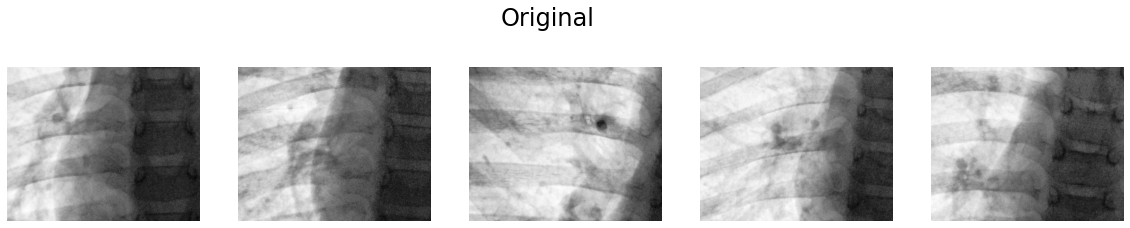

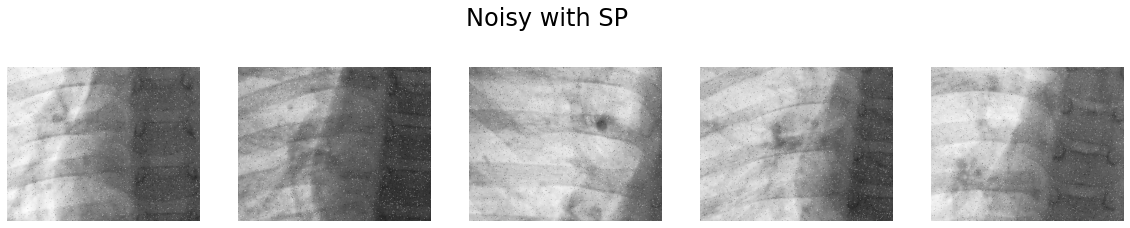

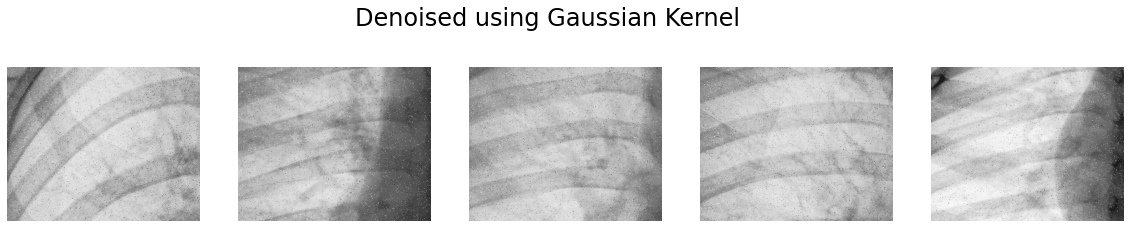

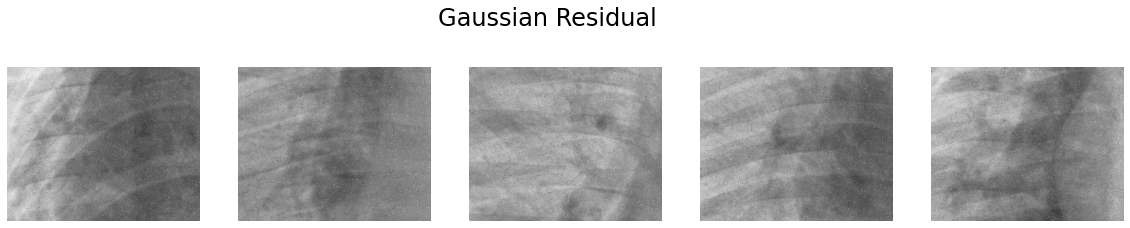

In [27]:
image_show(X_test[0:5], "Original")
image_show(X_test_noisy[0:5], "Noisy with SP")
image_show(gaussian_X_test_denoise[0:5],'Denoised using Gaussian Kernel')
image_show(gaussian_residual[0:5],'Gaussian Residual')

print("mse",np.mean((gaussian_residual) ** 2))

### 1.2 Polynomial kernel

In [12]:
#import the algorithm
poly_kernel_pca = KernelPCA(n_components=4000, kernel="poly", gamma=1e-3, degree = 4,fit_inverse_transform=True, alpha=5e-3)


#learn the data
poly_kernel_pca.fit(X_train_noisy)


#reconstruct the data
poly_X_test_denoise = poly_kernel_pca.inverse_transform(poly_kernel_pca.transform(X_test_noisy))

#calcualte the residual
poly_residual = X_test_noisy - poly_X_test_denoise



mse 364741.59750295186


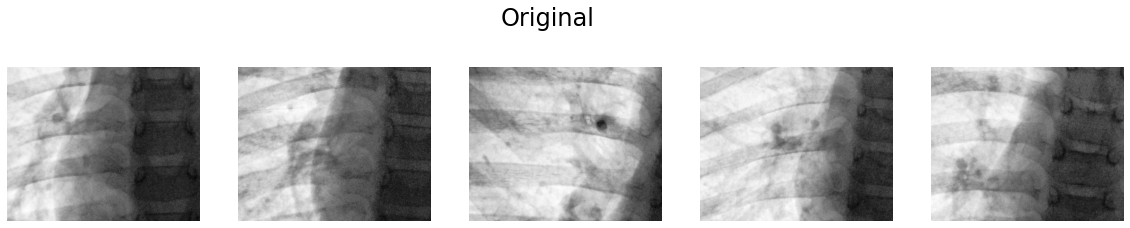

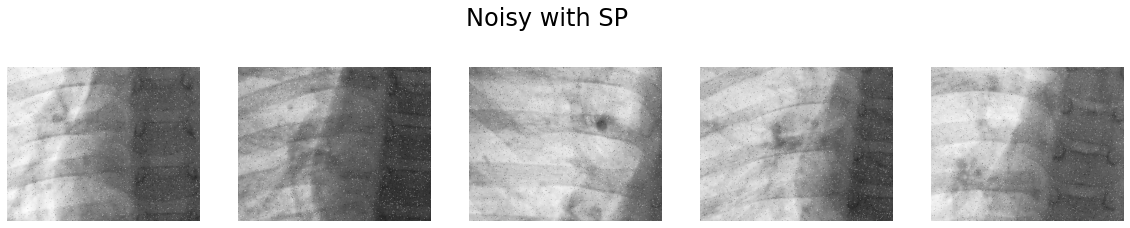

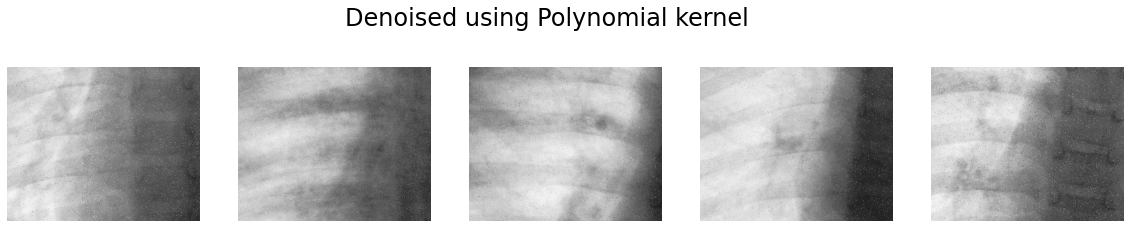

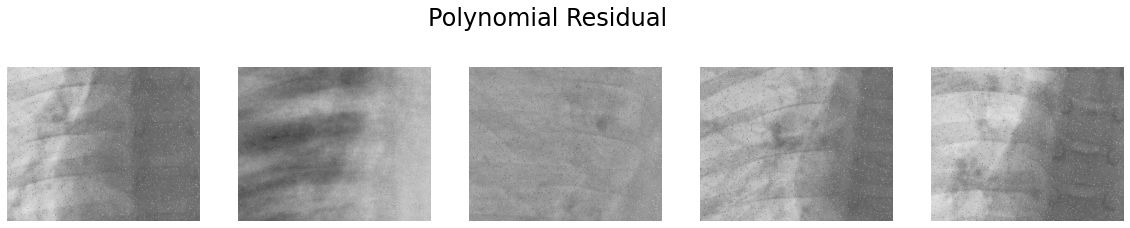

In [28]:
image_show(X_test[0:5], "Original")
image_show(X_test_noisy[0:5], "Noisy with SP")
image_show(poly_X_test_denoise[0:5],'Denoised using Polynomial kernel')
image_show(poly_residual[0:5],'Polynomial Residual')

print("mse",np.mean((poly_residual) ** 2))

### 1.3 sigmoid kernel

In [14]:
#import the algorithm
sigmoid_kernel_pca = KernelPCA(n_components=4000, kernel="sigmoid", coef0 = 2,fit_inverse_transform=True, alpha=5e-3)


#learn the data
sigmoid_kernel_pca.fit(X_train_noisy)


#reconstruct the data
sigmoid_X_test_denoise = sigmoid_kernel_pca.inverse_transform(sigmoid_kernel_pca.transform(X_test_noisy))

#calcualte the residual
sigmoid_residual = X_test_noisy - sigmoid_X_test_denoise

In [1]:
noisy_residual = X_test_noisy - X_test

NameError: name 'X_test_noisy' is not defined

mse 3529.9231223332986


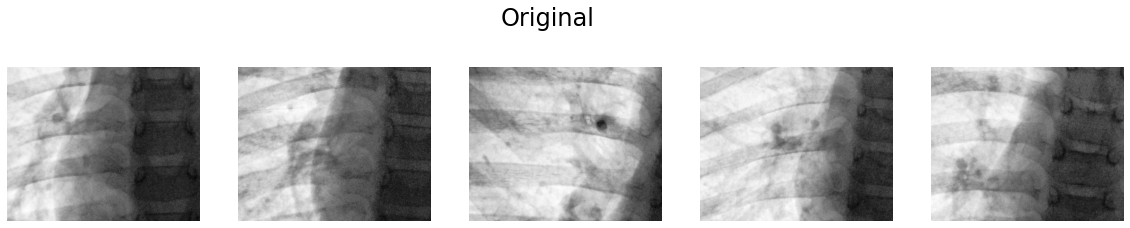

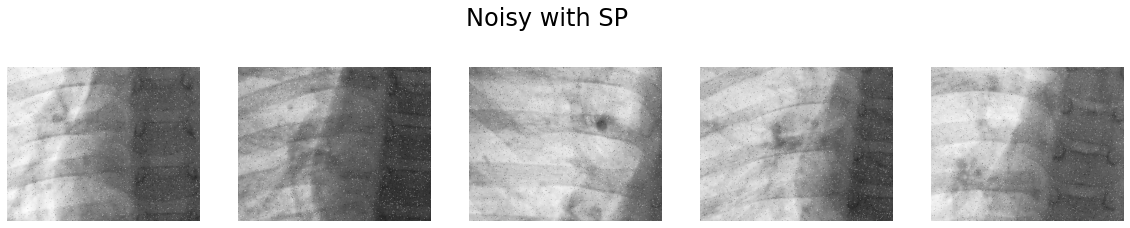

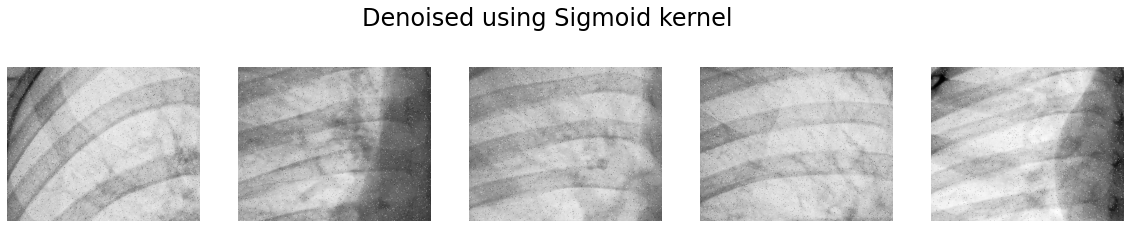

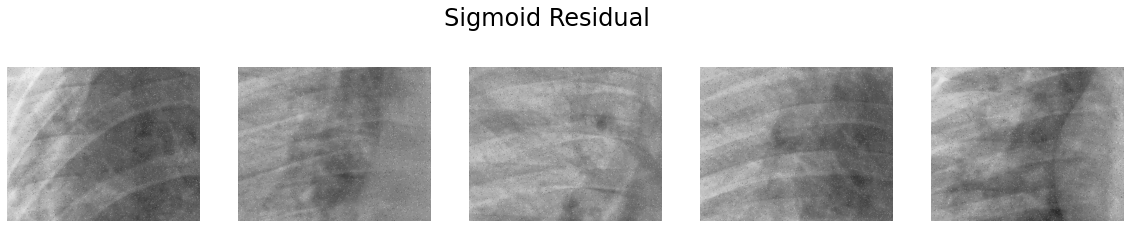

In [29]:
image_show(X_test[0:5], "Original")
image_show(X_test_noisy[0:5], "Noisy with SP")
image_show(sigmoid_X_test_denoise[0:5],'Denoised using Sigmoid kernel')
image_show(sigmoid_residual[0:5],'Sigmoid Residual')

print("mse",np.mean((sigmoid_residual) ** 2))

# Comparing 3 kernels for Salt and Pepper noise

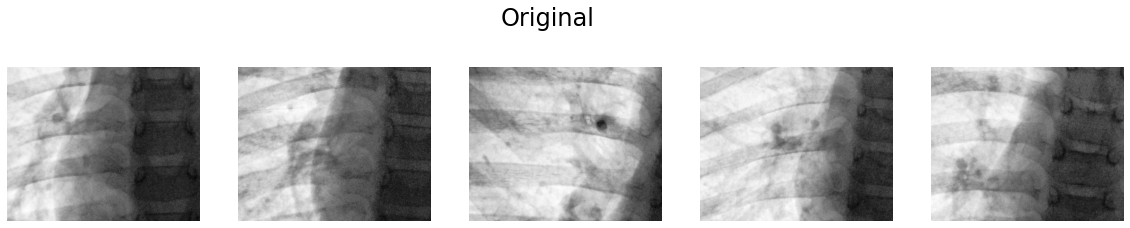

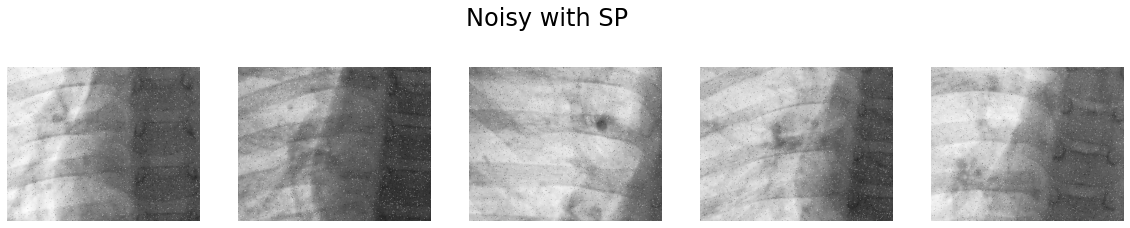

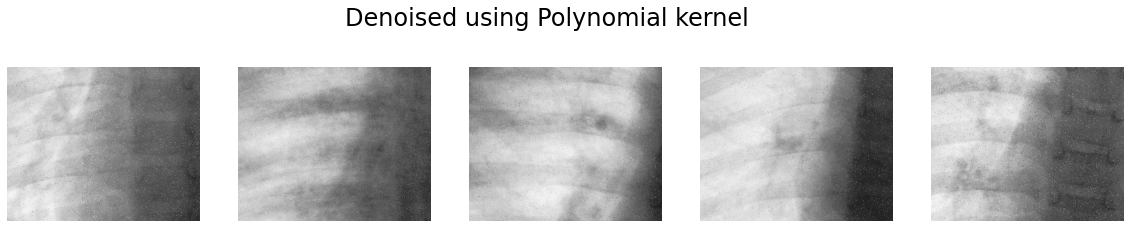

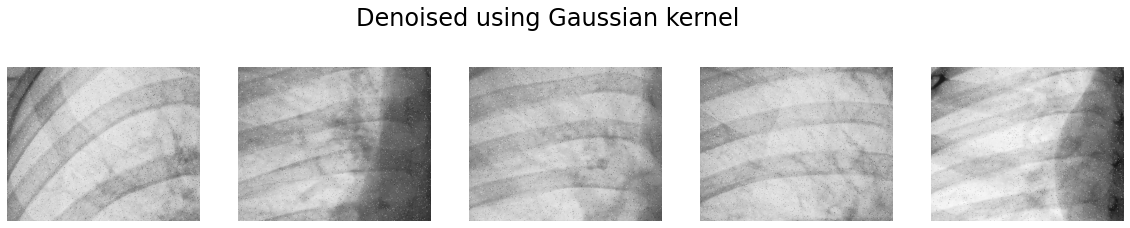

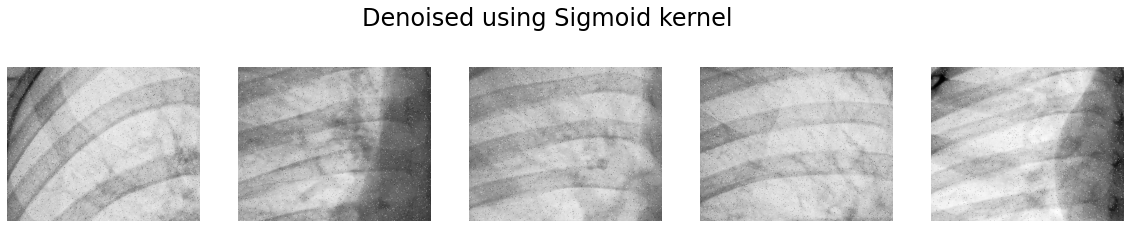

In [30]:
image_show(X_test[0:5], "Original")
image_show(X_test_noisy[0:5], "Noisy with SP")
noisy_residual = X_test_noisy - X_test
image_show(poly_X_test_denoise[0:5],'Denoised using Polynomial kernel')
image_show(gaussian_X_test_denoise[0:5], 'Denoised using Gaussian kernel')
image_show(sigmoid_X_test_denoise[0:5],'Denoised using Sigmoid kernel')


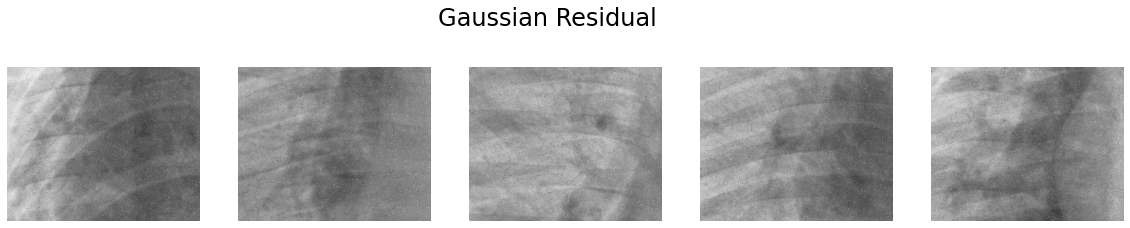

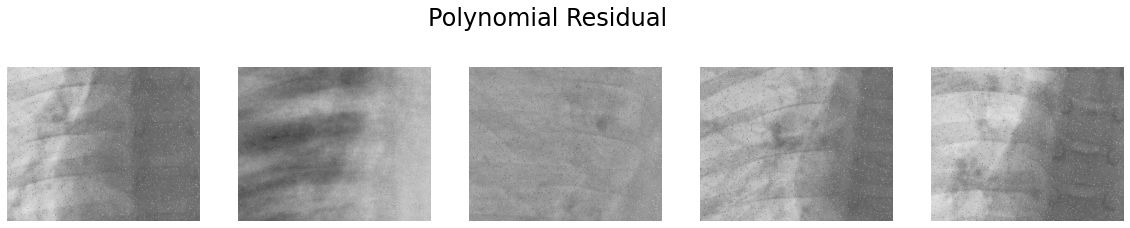

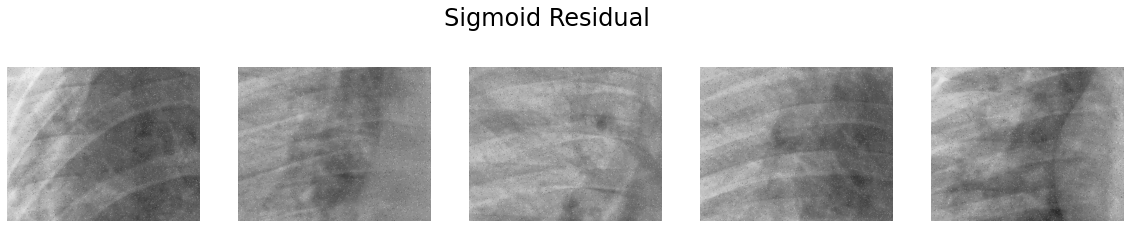

In [31]:
image_show(gaussian_residual[0:5],'Gaussian Residual')
image_show(poly_residual[0:5],'Polynomial Residual')
image_show(sigmoid_residual[0:5],'Sigmoid Residual')

In [32]:
print("gaussian mse",np.mean((gaussian_residual) ** 2))
print("polynomial mse",np.mean((poly_residual) ** 2))
print("sigmoid mse",np.mean((sigmoid_residual) ** 2))

gaussian mse 2687.814934896146
polynomial mse 364741.59750295186
sigmoid mse 3529.9231223332986
